# KAGGLE-LIKE CHALLENGE
On vous propose ici de tester tout ce que vous avez appris sur le machine learning supervisé, dans le but de faire un modèle de prédiction sur des données fournies, à la manière des compétitions Kaggle.

**Déroulement d'un challenge Kaggle**
- Kaggle vous envoie toujours deux datasets :
  - un fichier data_train.csv qui contient des données correspondant aux variables X, et au label Y à prédire. Utilisez ce fichier pour entraîner vos modèles comme d'habitude.
  - un fichier data_test.csv, qui contient les données X au même format que dans data_train.csv, mais cette fois les labels sont cachés. Votre but est de faire des prédictions sur ces données et de renvoyer ces prédictions à Kaggle, pour qu'ils évaluent votre modèle de manière indépendante
- Kaggle compare vos prédictions aux vrais labels et propose un leaderboard (équipes classées en fonction de leur score)
- Kaggle vous annonce à l'avance quelle métrique va être utilisée pour évaluer les modèles : veillez à utiliser la même métrique pour évaluer les performances de vos modèles

**Prédiction de conversion**

Ici, on vous propose d'essayer de créer le meilleur modèle pour prédire des conversions en fonction de différentes variables explicatives. Vos modèles seront évalués à l'aide du f1-score.

*Inspirez-vous du template ci-dessous pour la lecture des fichiers, la structure à suivre, et l'écriture des prédictions finales.*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix,f1_score

from sklearn.utils import resample

# Read file with labels

In [3]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


## Data vizualisation

In [4]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [6]:
# Basic stats
data_desc=data.describe(include='all')
print(data_desc)
data.shape


       country            age       new_user  source  total_pages_visited  \
count   284580  284580.000000  284580.000000  284580        284580.000000   
unique       4            NaN            NaN       3                  NaN   
top         US            NaN            NaN     Seo                  NaN   
freq    160124            NaN            NaN  139477                  NaN   
mean       NaN      30.564203       0.685452     NaN             4.873252   
std        NaN       8.266789       0.464336     NaN             3.341995   
min        NaN      17.000000       0.000000     NaN             1.000000   
25%        NaN      24.000000       0.000000     NaN             2.000000   
50%        NaN      30.000000       1.000000     NaN             4.000000   
75%        NaN      36.000000       1.000000     NaN             7.000000   
max        NaN     123.000000       1.000000     NaN            29.000000   

            converted  
count   284580.000000  
unique            NaN  
top

(284580, 6)

* target : Y = 'converted'
 
* features : 'country','age','new_user','source','total_pages_visited'

* number of samples : 284580

* numerical features  :'age', 'total_pages_visited'

* categorical features : 'country','new_user','source'

* encoding label:None

* missing value:None

* outlier:'age'

In [8]:
data.converted.value_counts(normalize=True)

0    0.967742
1    0.032258
Name: converted, dtype: float64

There is only 3.7% of converted

In [11]:
# Get a series object containing the count of unique elements
# in each column of dataframe
uniqueValues =data.nunique()
print('Count of unique values in each column :')
print(uniqueValues)

Count of unique values in each column :
country                 4
age                    60
new_user                2
source                  3
total_pages_visited    29
converted               2
dtype: int64


In [14]:
#lest's built a new dataset whith only converted==1

data1= data.loc[data["converted"]==1] 


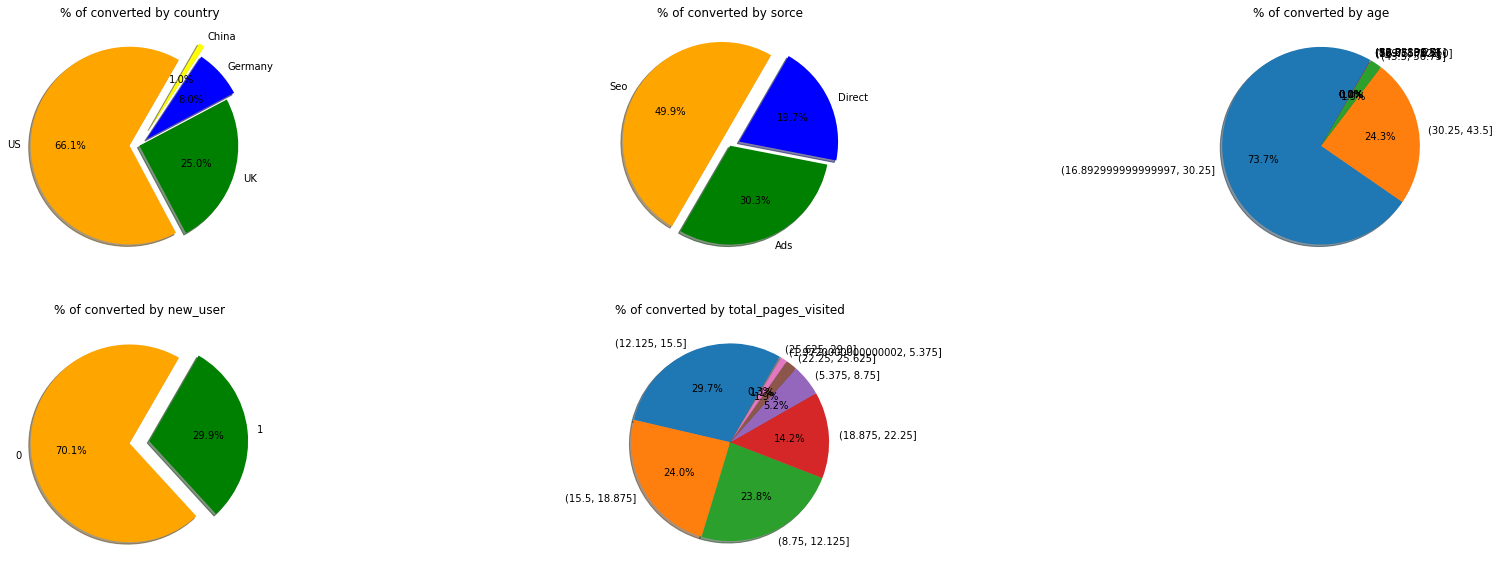

In [15]:
plt.figure(figsize=(30,10))

plt.subplot(231)
data1_country=data1.country.value_counts(normalize=True)
colors2=['orange','green','blue','yellow']
plt.title("% of converted by country")
plt.pie(data1_country.values,labels=data1_country.index,autopct='%1.1f%%',colors=colors2,explode=(0.1,0,0.1,0.2),
        shadow=True, startangle=60)

plt.subplot(232)
data1_source=data1.source.value_counts(normalize=True)
colors2=['orange','green','blue']
plt.title("% of converted by sorce")
plt.pie(data1_source.values,labels=data1_source.index,autopct='%1.1f%%',colors=colors2,explode=(0.1,0,0.1),
        shadow=True, startangle=60)


plt.subplot(233)
data1_age=data1.age.value_counts(normalize=True,bins=8)
plt.title("% of converted by age")
plt.pie(data1_age.values,labels=data1_age.index,autopct='%1.1f%%',
        shadow=True, startangle=60)

plt.subplot(234)
data1_new_user=data1.new_user.value_counts(normalize=True)
colors2=['orange','green']
plt.title("% of converted by new_user")
plt.pie(data1_new_user.values,labels=data1_new_user.index,autopct='%1.1f%%',colors=colors2,explode=(0.1,0.1),
        shadow=True, startangle=60)

plt.subplot(235)
data1_total_pages_visited=data1.total_pages_visited.value_counts(normalize=True,bins=8)
plt.title("% of converted by total_pages_visited")
plt.pie(data1_total_pages_visited.values,labels=data1_total_pages_visited.index,autopct='%1.1f%%',
        shadow=True, startangle=60)

plt.show()

* most of converted are in US
* Seo is the most efficient way of converting people
* most of buyers are in their twenties
* former buyers buy significantly more
* 90 % of converted visited between 6 and 20 pages. This rate drops above 20 and below 6 visited pages

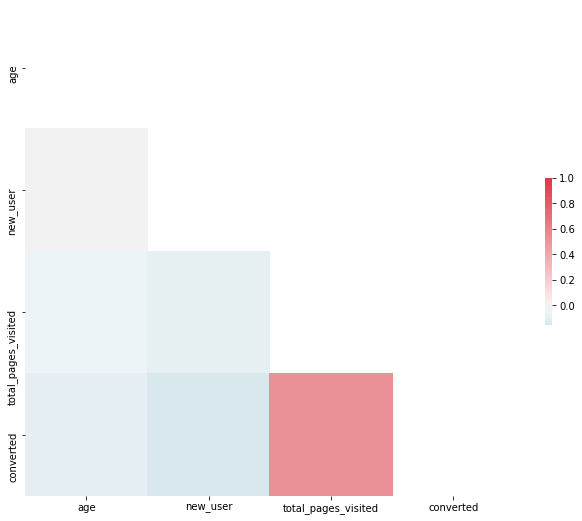

In [16]:
# Check correlations
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap = cmap, square=True,  
            center=0, cbar_kws={"shrink": .3})

#  Data Cleaning

In [35]:
data.age.value_counts(ascending=True).head(10)

79.0     1
77.0     1
73.0     1
69.0     1
72.0     1
68.0     2
70.0     2
67.0     5
66.0     9
65.0    14
Name: age, dtype: int64

In [36]:
outlier=100
data.age=np.where(data.age>=100,np.median(data.age),data.age)

In [37]:
data.age.value_counts(ascending=True).head()

79.0    1
77.0    1
73.0    1
69.0    1
72.0    1
Name: age, dtype: int64

In [38]:
features_list = ['country','age','new_user','source','total_pages_visited']
numeric_indices = [1,4]
categorical_indices = [0,2,3]
target_variable = 'converted'

In [39]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Variables explicatives : ', X.columns)
print()

Variables explicatives :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [40]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [41]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[['US' 20.0 1 'Ads' 4]
 ['China' 29.0 1 'Ads' 3]
 ['US' 36.0 0 'Seo' 3]
 ['US' 23.0 1 'Seo' 8]
 ['UK' 41.0 1 'Ads' 3]]
[['US' 32.0 1 'Seo' 4]
 ['UK' 30.0 1 'Seo' 5]]

[0 0 0 0 0]
[0 0]


## Training pipeline

In [42]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")


# Normalization
numeric_transformer = StandardScaler()
    
# OHE / dummyfication
categorical_transformer = OneHotEncoder(drop='first')
featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]    )

X_train = featureencoder.fit_transform(X_train)

print("...Done")
print(X_train[0:5,:])



Encoding categorical features and standardizing numerical features...
...Done
[[ 0.          0.          1.          1.          0.          0.
  -1.27672689 -0.2618471 ]
 [ 0.          0.          0.          1.          0.          0.
  -0.18866674 -0.56090876]
 [ 0.          0.          1.          0.          0.          1.
   0.65760226 -0.56090876]
 [ 0.          0.          1.          1.          0.          1.
  -0.91404017  0.93439955]
 [ 0.          1.          0.          1.          0.          0.
   1.26208012 -0.56090876]]


In [43]:
# Train model
print("Train model...")
classifier = LogisticRegressionCV(class_weight={0:0.50,1:0.8}) # regularized logit with regularization strength chosen by cross-val
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...


C:\Users\jrala\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


...Done.


In [44]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [45]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.          0.          1.          1.          0.          1.
   0.17401997 -0.2618471 ]
 [ 0.          1.          0.          1.          0.          1.
  -0.06777117  0.03721457]
 [ 0.          0.          0.          1.          0.          1.
   0.0531244   0.03721457]
 [ 0.          0.          1.          0.          0.          1.
   2.47103583  0.03721457]
 [ 0.          0.          1.          1.          1.          0.
  -1.27672689 -0.56090876]]


In [46]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [50]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7690342723337826
f1-score on test set :  0.7744680851063831


In [51]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[218990   1330]
 [  1925   5419]]

Confusion matrix on test set : 
[[54756   324]
 [  471  1365]]



Coefficients du modèle: 


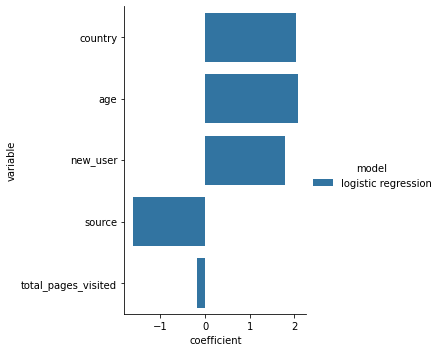

In [49]:
# Model coefficients
data = {
    "model": ["logistic regression" for i in features_list],
    "variable": [i for i in features_list],
    "coefficient": [classifier.coef_[0,i] for i in range(len(features_list))]
}
models_coefs = pd.DataFrame(columns = {"model","variable","coefficient"}, data = data)


print('Coefficients du modèle: ')
sns.catplot(x="coefficient", y="variable", hue="model", kind='bar',
            data=models_coefs.loc[models_coefs['model']=="logistic regression",:])


In [48]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

C:\Users\jrala\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight={0: 0.5, 1: 0.8}, cv='warn',
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='warn',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [52]:
Y_pred = classifier.predict(X)

In [53]:
print("Confusion matrix on all data: ")
print(confusion_matrix(Y, Y_pred))
print()

Confusion matrix on all data: 
[[273813   1587]
 [  2460   6720]]

